# ML Part Regression

In [531]:
#df_compact_30 = df_compact.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
#df_train_gen , df_test_gen = df_train.copy(), df_test.copy()
df_train, df_test = train_dfs_list[0], test_dfs_list[0]

In [532]:
df_train = df_train.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
df_test = df_test.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)

In [533]:
#df_compact_30 = df_compact_30[df_compact_30['future_30dprice_change'].notna()]
df_train = df_train[df_train['future_30dprice_change'].notna()]
df_test = df_test[df_test['future_30dprice_change'].notna()]

In [534]:
#df_train, df_test = train_test_split(df_compact_30, test_size=0.2, random_state=42)

Light GBM can work with categoricl features 8x faster without using OneHotEncoder.
But transforming string to int is still required

In [535]:
le = LabelEncoder()
le.fit(df_train["sector"])


df_train["sector"] = le.transform(df_train["sector"])
df_test["sector"] = le.transform(df_test["sector"])

In [536]:
df_train.drop('stock', axis = 1, inplace = True)
df_test.drop('stock', axis = 1, inplace = True)

In [537]:
#Creating the x, y variables 
y_train = df_train['future_30dprice_change']
y_test = df_test['future_30dprice_change']

x_train = df_train.drop('future_30dprice_change', axis = 1)
x_test = df_test.drop('future_30dprice_change', axis = 1)

### Creating a model

In [538]:
lgbm = lgb.LGBMRegressor(random_state=42,n_jobs = 5, n_estimators = 50)
lgbm.fit(x_train, y_train, categorical_feature=['sector'])

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMRegressor(n_estimators=50, n_jobs=5, random_state=42)

In [539]:
#predicting on test set
ypred=lgbm.predict(x_test)

In [540]:
#calculating accuracy
accuracy_30d = mae(y_test, ypred)
print(f"Accuracy of prediction:{accuracy_30d:0.4f}")

Accuracy of prediction:9.0528


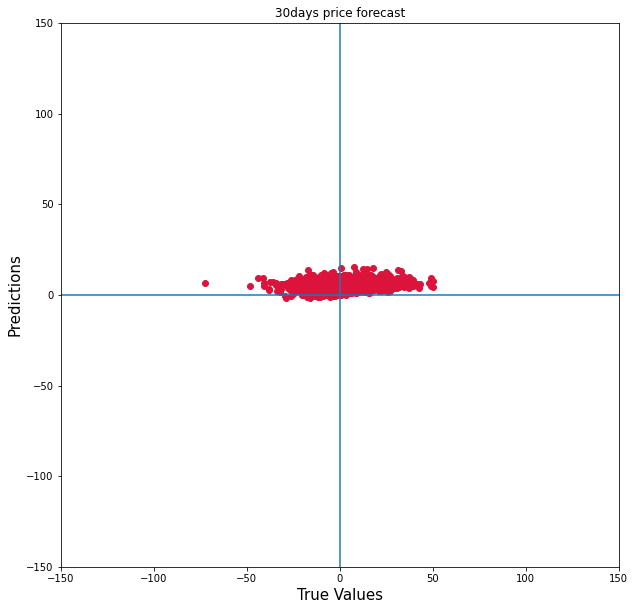

In [541]:
def true_predict_plot(y_val, ypred, title):
    plt.figure(figsize=(10,10))
    plt.scatter(y_val, ypred, c='crimson')
    plt.yscale('linear')
    plt.xscale('linear')

    p1 = max(max(ypred), max(y_val))
    p2 = min(min(ypred), min(y_val))
    #plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.ylim(-150, 150)
    plt.xlim(-150, 150)
    #plt.axis('equal')
    plt.axvline(x=0)
    plt.axhline(y=0)
    plt.title(title)
    plt.show()
    
true_predict_plot(y_test, ypred,'30days price forecast')

In [542]:
def accuracy_df(y_test, ypred):
    df_y_vals = pd.DataFrame()
    df_y_vals["Real"] = y_test
    df_y_vals["Prediction"] = ypred
    df_y_vals["Delta"] = df_y_vals["Real"] - df_y_vals["Prediction"]
    df_y_vals["Correct"] = 0
    df_y_vals.loc[((df_y_vals['Real'] >0) & (df_y_vals['Prediction'] >0)) | ((df_y_vals['Real'] <0) & (df_y_vals['Prediction'] <0)),'Correct'] = 1

    true_false_values = df_y_vals.groupby("Correct").count().Real.to_frame()

    true_false_values["Value, %"] = (true_false_values['Real'] / true_false_values['Real'].sum()) * 100
    true_false_values["Value, %"] = true_false_values["Value, %"].round(2)
    print(true_false_values)

    print("\nTotal cases evaluated:",true_false_values.Real.sum())
    return true_false_values

acc_percent_30d = accuracy_df(y_test, ypred)
acc_percent_30d = acc_percent_30d["Value, %"][1]

         Real  Value, %
Correct                
0        2382      43.0
1        3157      57.0

Total cases evaluated: 5539


We got 57% acuracy for the 500 companies. That is not bad. Let's check if we get better results with the other prediction periods.

### Let's see how we perform with the other forecast periods

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


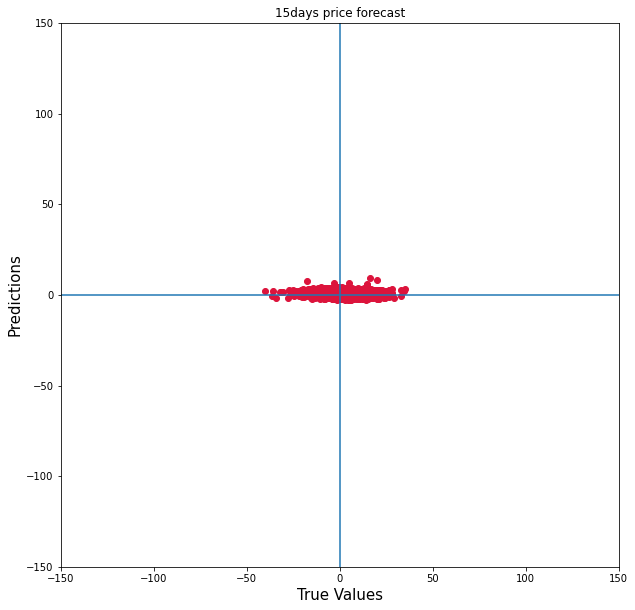

Accuracy of prediction:6.1166


Increase or decrease predicted correctly:
         Real  Value, %
Correct                
0        3814     58.31
1        2727     41.69

Total cases evaluated: 6541
    Value                     Feature   Value, %
37    214           days_after_crisis  14.266667
36    137                    VIX_high   9.133333
35    116                      sector   7.733333
34    103                    10YB_YoY   6.866667
33    102                     VIX_WoW   6.800000
32     96                     VIX_MoM   6.400000
31     69             10Y_Val_to_30MA   4.600000
30     67                     10YBond   4.466667
29     63            10Y_Val_to_200MA   4.200000
28     60           10YB_200MA_Vector   4.000000
27     59                    10YB_MoM   3.933333
26     40                     VIX_DoD   2.666667
25     39                          PE   2.600000
24     38                      YoY_DY   2.533333
23     34              EPS_YoY_Growth   2.266667
22     31        

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


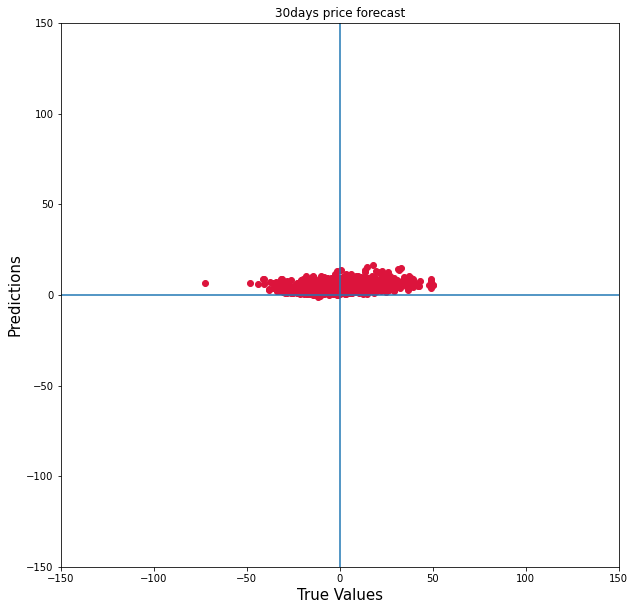

Accuracy of prediction:9.3239


Increase or decrease predicted correctly:
         Real  Value, %
Correct                
0        3304      50.9
1        3187      49.1

Total cases evaluated: 6491
    Value                     Feature   Value, %
37    228           days_after_crisis  15.200000
36    153                      sector  10.200000
35     97                    10YB_YoY   6.466667
34     95                    VIX_high   6.333333
33     69           10YB_200MA_Vector   4.600000
32     62                     VIX_MoM   4.133333
31     55                     10YBond   3.666667
30     52                      YoY_PE   3.466667
29     51             10Y_Val_to_30MA   3.400000
28     49            10Y_Val_to_200MA   3.266667
27     45              EPS_YoY_Growth   3.000000
26     44                      YoY_DY   2.933333
25     43                          PE   2.866667
24     38                          DY   2.533333
23     38                    10YB_MoM   2.533333
22     33        

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


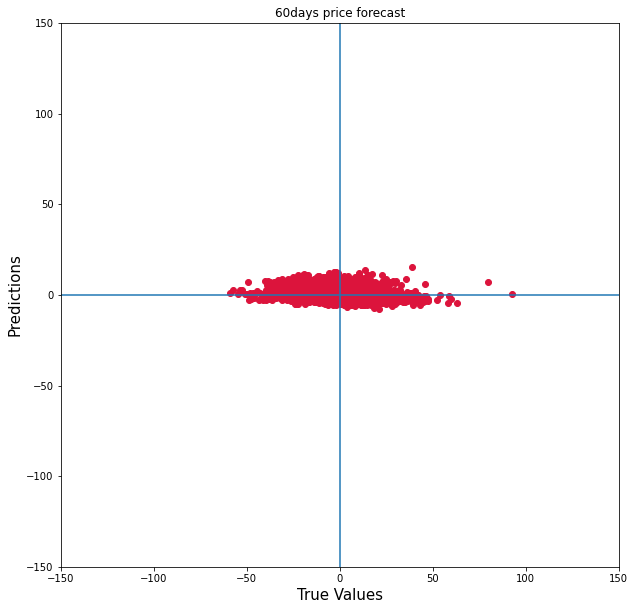

Accuracy of prediction:13.8357


Increase or decrease predicted correctly:
         Real  Value, %
Correct                
0        4625     72.37
1        1766     27.63

Total cases evaluated: 6391
    Value                     Feature   Value, %
37    192           days_after_crisis  12.800000
36    171                      sector  11.400000
35     63           10YB_200MA_Vector   4.200000
34     58                    10YB_YoY   3.866667
33     56                    VIX_high   3.733333
32     54                          PE   3.600000
31     54                          DY   3.600000
30     54                     10YBond   3.600000
28     53                         ROE   3.533333
29     53                      YoY_DY   3.533333
27     52                          CR   3.466667
26     48                      YoY_PE   3.200000
25     45                          ES   3.000000
24     41           EPS_1Y_exp_Change   2.733333
23     40                EPS_surprise   2.666667
22     39       

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


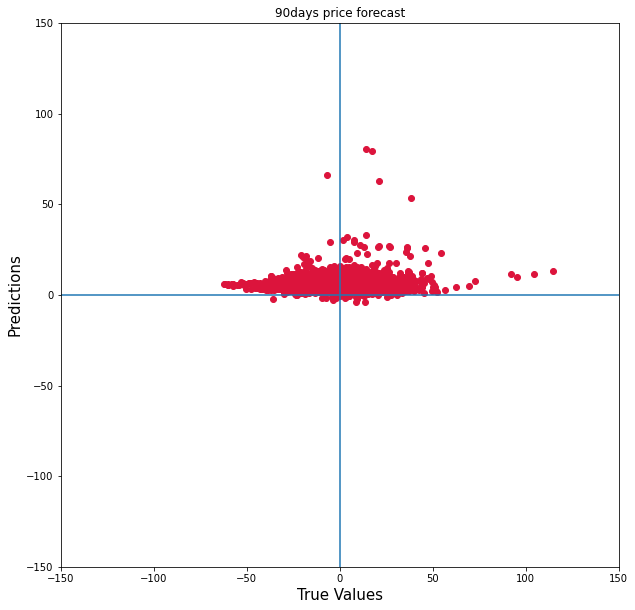

Accuracy of prediction:12.7986


Increase or decrease predicted correctly:
         Real  Value, %
Correct                
0        3417     54.32
1        2874     45.68

Total cases evaluated: 6291
    Value                     Feature   Value, %
37    202           days_after_crisis  13.466667
36    199                      sector  13.266667
35     72                          CR   4.800000
34     66           EPS_1Y_exp_Change   4.400000
33     65                          PE   4.333333
32     56                          DY   3.733333
31     55                    10YB_YoY   3.666667
30     52                      YoY_DY   3.466667
29     47                      YoY_CR   3.133333
28     44                          DE   2.933333
27     43                          ES   2.866667
26     42              EPS_YoY_Growth   2.800000
25     41                         ROE   2.733333
24     39                    VIX_high   2.600000
23     39                          GM   2.600000
22     38       

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


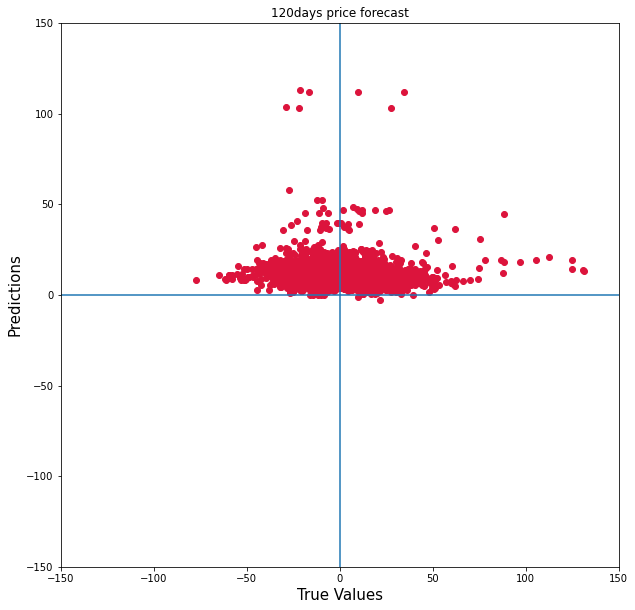

Accuracy of prediction:17.8491


Increase or decrease predicted correctly:
         Real  Value, %
Correct                
0        3447     55.68
1        2744     44.32

Total cases evaluated: 6191
    Value                     Feature   Value, %
37    196                      sector  13.066667
36    162           days_after_crisis  10.800000
35     82           EPS_1Y_exp_Change   5.466667
34     77                          DY   5.133333
33     62                          PE   4.133333
32     61                          CR   4.066667
31     57                          GM   3.800000
30     55                      YoY_DY   3.666667
29     51                          DE   3.400000
28     45              EPS_YoY_Growth   3.000000
27     43                      YoY_CR   2.866667
26     42                         ROE   2.800000
25     42            10Y_Val_to_200MA   2.800000
24     41          Acc_Rec_Pay_Ration   2.733333
23     39                          ES   2.600000
22     38       

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


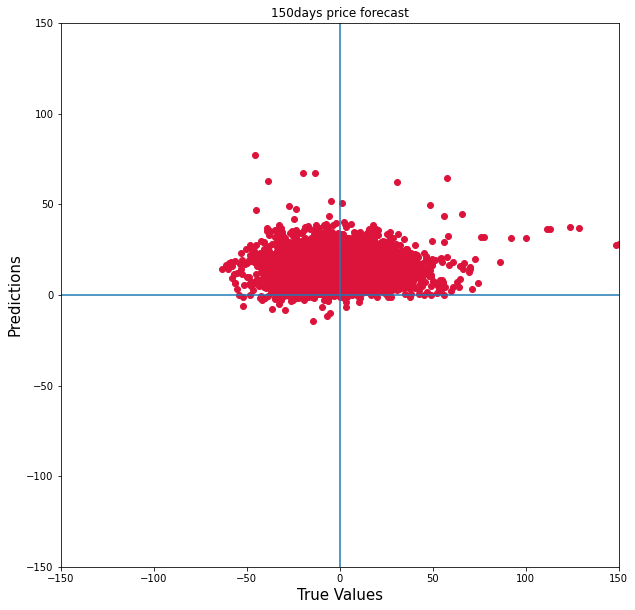

Accuracy of prediction:21.4898


Increase or decrease predicted correctly:
         Real  Value, %
Correct                
0        3440     56.48
1        2651     43.52

Total cases evaluated: 6091
    Value                     Feature   Value, %
37    198                      sector  13.200000
36    135           days_after_crisis   9.000000
35     92           EPS_1Y_exp_Change   6.133333
34     74                          DY   4.933333
33     63                          CR   4.200000
32     59                          DE   3.933333
31     56          Acc_Rec_Pay_Ration   3.733333
30     53              EPS_YoY_Growth   3.533333
29     52                          PE   3.466667
28     51                         ROE   3.400000
27     45                      YoY_DY   3.000000
26     45                    VIX_high   3.000000
25     45                          GM   3.000000
24     44                          ES   2.933333
23     42                      YoY_CR   2.800000
22     40       

In [543]:
targets_all =["future_15dprice_change","future_30dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"]
periods = ["15days", "30days", "60days", "90days", "120days", "150days"]

MAEs = []
acc_percent_list = []
feature_importances = []
list_of_regression_models = []

for j, i in enumerate(targets_all):
    remove_redundant_list = list(targets_all)
    remove_redundant_list.remove(i)

    #df_compact_temp = df_compact.drop(remove_redundant_list,axis = 1)
    #df_compact_temp = df_compact_temp[df_compact_temp[i].notna()]
    
    df_train, df_test = train_dfs_list[j], test_dfs_list[j]
    df_train = df_train.drop(remove_redundant_list,axis = 1).copy()
    df_test = df_test.drop(remove_redundant_list,axis = 1).copy()
    df_train = df_train[df_train[i].notna()]
    df_test = df_test[df_test[i].notna()]
    #df_train, df_test = train_test_split(df_compact_temp, test_size=0.2, random_state=42)

    df_train.drop(["stock"], axis = 1, inplace = True)
    df_test.drop(["stock"], axis = 1, inplace = True)

    le = LabelEncoder()
    le.fit(df_train["sector"])
    df_train["sector"] = le.transform(df_train["sector"])
    df_test["sector"] = le.transform(df_test["sector"])

    #Creating the x, y variables 
    y_train = df_train[i]
    y_test = df_test[i]

    x_train = df_train.drop(i, axis = 1)
    x_test = df_test.drop(i, axis = 1)

    lgbm = lgb.LGBMRegressor(random_state=42,n_jobs = 5, n_estimators = 50)
    list_of_regression_models.append(lgbm)
    lgbm.fit(x_train, y_train, categorical_feature=['sector'])

    #predicting on test set
    ypred=lgbm.predict(x_test)

    true_predict_plot(y_test, ypred, periods[j] +' price forecast')

    #calculating accuracy
    from sklearn.metrics import mean_absolute_error as mae
    accuracy = mae(y_test, ypred)
    MAEs.append(accuracy)
    print(f"Accuracy of prediction:{accuracy:0.4f}")

    print("\n\nIncrease or decrease predicted correctly:")
    acc_percent = accuracy_df(y_test, ypred)
    acc_percent = acc_percent["Value, %"][1]
    acc_percent_list.append(acc_percent)
    
    feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_train.columns)), columns=['Value','Feature'])
    feature_imp["Value, %"] = (feature_imp['Value'] / feature_imp['Value'].sum()) * 100
    print(feature_imp.sort_values(by='Value, %', ascending=False))
    feature_importances.append(feature_imp[["Feature", "Value, %"]])

### Result summarization

In [544]:
MAEs = [round(x*100,2) for x in MAEs]

index = [15,30,60,90,120,150]
accuracy_compare_dt = {"Absolute Error":MAEs,"Correctly Predicted Price Direction":acc_percent_list}
accuracy_compare_df= pd.DataFrame(accuracy_compare_dt, index=index)
accuracy_compare_df.index.name = "Forecasted Period, days"

print(accuracy_compare_df)

                         Absolute Error  Correctly Predicted Price Direction
Forecasted Period, days                                                     
15                               611.66                                41.69
30                               932.39                                49.10
60                              1383.57                                27.63
90                              1279.86                                45.68
120                             1784.91                                44.32
150                             2148.98                                43.52


We see that error is above 50% that states that the model performance is poor.

In [545]:
all_features_evolution = []
for i, j in enumerate(feature_importances):
    features_sorted = feature_importances[i].sort_values(by='Value, %', ascending=False)["Feature"].tolist()
    all_features_evolution.append(features_sorted)

features_evolution = pd.DataFrame(all_features_evolution, index = index)
accuracy_compare_df.index.name = "Forecasted Period, days"
features_evolution

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
15,days_after_crisis,VIX_high,sector,10YB_YoY,VIX_WoW,VIX_MoM,10Y_Val_to_30MA,10YBond,10Y_Val_to_200MA,10YB_200MA_Vector,...,YoY_GM,YoY_PEGF,YoY_PEGB,GM,DPR,PEG_Forward,Acc_Rec_Pay_Ration,YoY_ES,PEG_Backwards,Piotroski_Score
30,days_after_crisis,sector,10YB_YoY,VIX_high,10YB_200MA_Vector,VIX_MoM,10YBond,YoY_PE,10Y_Val_to_30MA,10Y_Val_to_200MA,...,YoY_Piotroski,YoY_PEGB,YoY_DPR,EPS_QoQ_frcst_diff,Acc_Rec_Pay_Ration,YoY_ES,DPR,PEG_Backwards,PEG_Forward,Piotroski_Score
60,days_after_crisis,sector,10YB_200MA_Vector,10YB_YoY,VIX_high,PE,DY,10YBond,ROE,YoY_DY,...,YoY_GM,YoY_Piotroski,PEG_Forward,10Y_Val_to_30MA,PEG_Backwards,10YB_MoM,EPS_QoQ_frcst_diff,days_after_earnings_report,VIX_DoD,Piotroski_Score
90,days_after_crisis,sector,CR,EPS_1Y_exp_Change,PE,DY,10YB_YoY,YoY_DY,YoY_CR,DE,...,YoY_Piotroski,PEG_Backwards,VIX_MoM,Piotroski_Score,10Y_Val_to_30MA,10YB_MoM,days_after_earnings_report,EPS_QoQ_frcst_diff,VIX_WoW,VIX_DoD
120,sector,days_after_crisis,EPS_1Y_exp_Change,DY,PE,CR,GM,YoY_DY,DE,EPS_YoY_Growth,...,VIX_MoM,Piotroski_Score,PEG_Backwards,YoY_PEGB,10YB_MoM,10Y_Val_to_30MA,days_after_earnings_report,VIX_WoW,EPS_QoQ_frcst_diff,VIX_DoD
150,sector,days_after_crisis,EPS_1Y_exp_Change,DY,CR,DE,Acc_Rec_Pay_Ration,EPS_YoY_Growth,PE,ROE,...,YoY_PEGB,PEG_Backwards,VIX_MoM,Piotroski_Score,10YB_MoM,EPS_QoQ_frcst_diff,10Y_Val_to_30MA,VIX_WoW,VIX_DoD,days_after_earnings_report


As we see our model finds external factors as bonds rate and fear level as the best predictors even for the long term forecast. 
Dividends change timing also play it's role as the industry compny works in.
My expectation was to see PE ratio in the top 5, but it seems it doesn't play a big role. 

## Changing the perspective